In [1]:
import sys
import os

project_root = os.path.abspath(os.path.join(os.getcwd(), '../..'))
if project_root not in sys.path:
    sys.path.append(project_root)

In [4]:
import pathlib

import matplotlib.lines as mlines
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from Bio import SeqIO
from src.preprocessing.sequence_representations import NucleotideMappingMethod
from src.preprocessing.sequence_transformations import (
    TransformationHuffman,
    TransformationRefined,
    TransformationRudimentary,
)

In [5]:
def read_dna_data_from_file(file_path: str) -> tuple[list[str], list[int]]:
    sequences: list[str] = []
    classes: list[int] = []

    with open(file_path, "r") as file:
        for record in SeqIO.parse(file, "fasta"):
            seq_str: str = str(record.seq)
            # The class is the last character in the sequence
            class_label: int = int(seq_str[-1])
            dna_sequence: str = seq_str[:-1]

            sequences.append(dna_sequence)
            classes.append(class_label)

    return sequences, classes

In [4]:
sequences, classes = [], []

for file_path in pathlib.Path("../data/classification").glob("*.txt"):
    file_sequences, file_classes = read_dna_data_from_file(file_path)
    sequences.extend(file_sequences)
    classes.extend(file_classes)
    break

In [5]:
df = pd.DataFrame({"sequences": sequences, "classes": classes})

In [6]:
df.head()

,sequences,classes
0,CACACCACACCCACACACCCACACACCACACCACACACCACACCAC...,0
1,TTTCTAAGTGGGATTTTTCTTAATCCTTGGATTCTTAAAAGGTTAT...,1
2,AAAGCCATTAAGGTCCAGATAACCAAGGGACAATAAACCTATGCTT...,1
3,CCATCATTTTACTTCCACATAAGTTCTAATGTTACGTAGTTCAATT...,0
4,AATTATATTTCCATCAGCTCAATACCGCAGTACTTTGAAACCTGAT...,0


In [7]:
df["sequences"].map(len).describe()

count    14601.000000
mean       499.983494
std          1.628030
min        310.000000
25%        500.000000
50%        500.000000
75%        500.000000
max        500.000000
Name: sequences, dtype: float64

In [8]:
sequences_len_diff_500 = df[df["sequences"].map(len) != 500]

In [9]:
sequences_len_diff_500.head(2)

,sequences,classes
0,CACACCACACCCACACACCCACACACCACACCACACACCACACCAC...,0
263,TTATATTTGTTTAAATTGGATTTGTTTACATTAGATTTGTTTACAT...,0


<Axes: xlabel='classes', ylabel='count'>

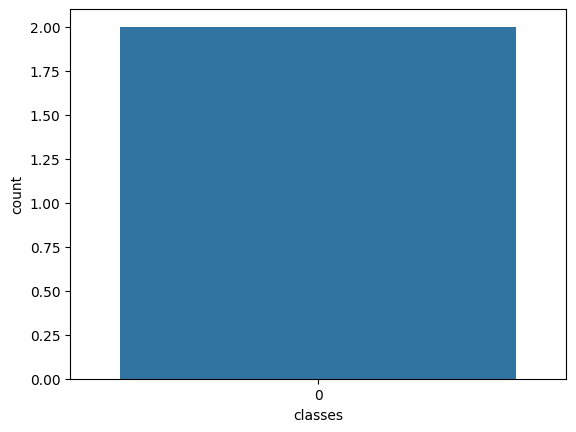

In [10]:
sns.countplot(x=sequences_len_diff_500["classes"])

We will drop the sequences with length different from 500

In [11]:
df.shape

(14601, 2)

In [12]:
len(sequences_len_diff_500.index)

2

In [13]:
df.drop(sequences_len_diff_500.index, inplace=True)
df.reset_index(inplace=True, drop=True)

In [14]:
(df["sequences"].map(len) != 500).sum()

0

The distribution of the labels

<Axes: xlabel='classes', ylabel='count'>

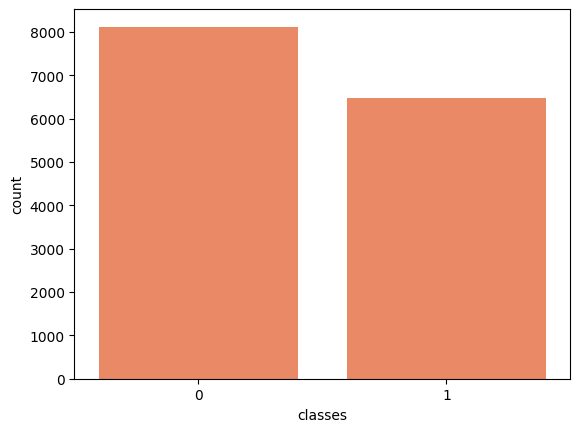

In [15]:
sns.countplot(x=df["classes"], color="coral")

In [16]:
sampled_df = df.groupby("classes", group_keys=False).apply(
    lambda x: x.sample(100, random_state=312)
)

/tmp/ipykernel_11225/2569573567.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_df = df.groupby("classes", group_keys=False).apply(


In [17]:
# Rudimentary
rudimentary_df_sample = sampled_df.copy()
rudimentary_df_sample["sequences"] = rudimentary_df_sample["sequences"].map(
    TransformationRudimentary().transform
)

# Refined
refined_df_sample = sampled_df.copy()
refined_df_sample["sequences"] = refined_df_sample["sequences"].map(
    TransformationRefined().transform
)


# Huffman
def transform_sequence_huffman(x: str) -> np.ndarray:
    return TransformationHuffman(x).transform(x)


huffman_df_sample = sampled_df.copy()
huffman_df_sample["sequences"] = huffman_df_sample["sequences"].map(
    transform_sequence_huffman
)

In [18]:
CLASS_COLORS = {0: "orange", 1: "green"}


def plot_sequence(row, ax):
    sequence = row["sequences"]
    class_label = row["classes"]
    x, y = zip(*sequence)
    color = CLASS_COLORS[class_label]
    ax.plot(x, y, color=color, linestyle="-", marker="o", markersize=0.7)


def create_legend_handle(class_label):
    color = CLASS_COLORS[class_label]
    return mlines.Line2D(
        [],
        [],
        color=color,
        marker="o",
        linestyle="None",
        markersize=10,
        label=f"Class {class_label}",
    )


def plot_sequences(df: pd.DataFrame, plot_title: str) -> None:
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.set_xlabel("x")
    ax.set_ylabel("y")

    for index, row in df.iterrows():
        plot_sequence(row, ax)

    legend_handles = [create_legend_handle(label) for label in CLASS_COLORS.keys()]
    ax.legend(handles=legend_handles)

    plt.title(plot_title)
    plt.show()

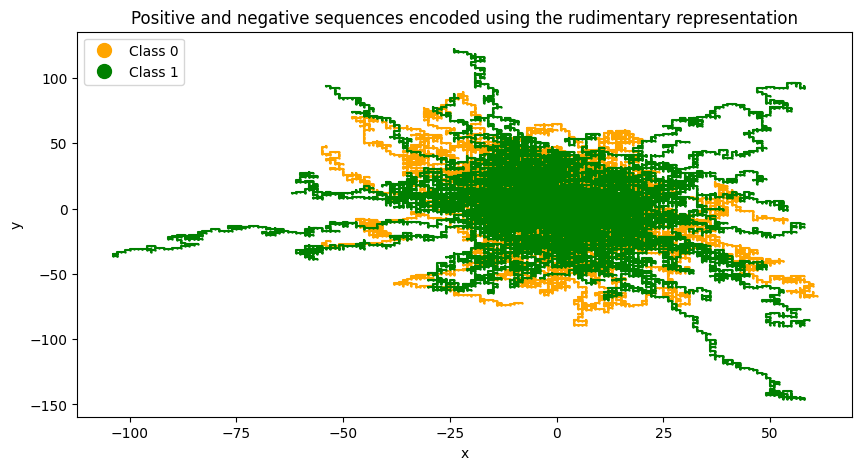

In [19]:
plot_sequences(
    rudimentary_df_sample,
    "Positive and negative sequences encoded using the rudimentary representation",
)

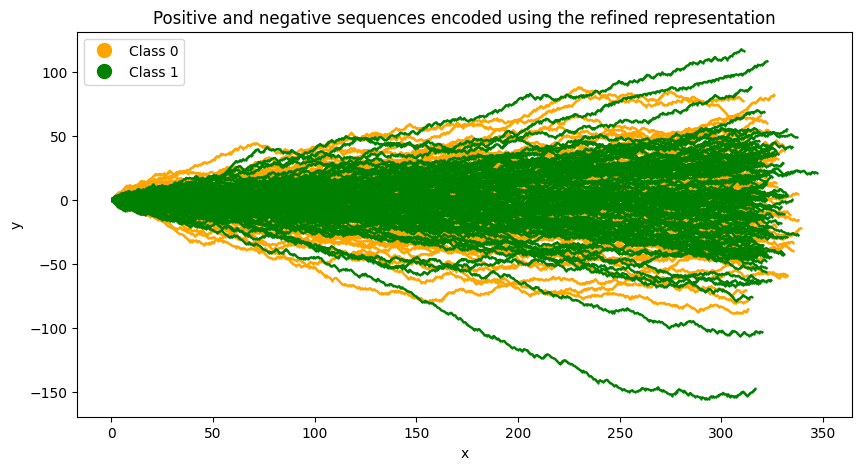

In [20]:
plot_sequences(
    refined_df_sample,
    "Positive and negative sequences encoded using the refined representation",
)

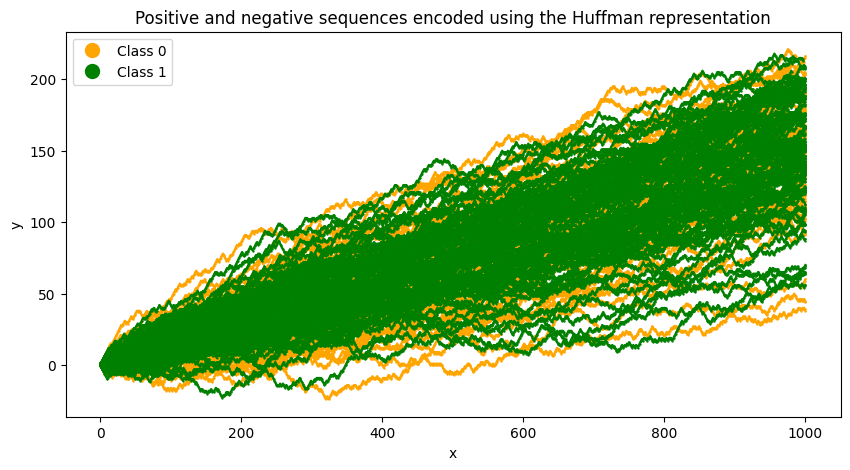

In [21]:
plot_sequences(
    huffman_df_sample,
    "Positive and negative sequences encoded using the Huffman representation",
)

# Scaling

In [22]:
def min_max_scale_globally(sequences: np.ndarray) -> pd.Series:
    combined_sequences = np.vstack(sequences)

    min_x, min_y = combined_sequences[:, 0].min(), combined_sequences[:, 1].min()
    max_x, max_y = combined_sequences[:, 0].max(), combined_sequences[:, 1].max()

    def min_max_scale_sequence(sequence: np.array) -> np.array:
        x_scaled = 2 * ((sequence[:, 0] - min_x) / (max_x - min_x)) - 1
        y_scaled = 2 * ((sequence[:, 1] - min_y) / (max_y - min_y)) - 1
        return pd.Series(np.column_stack((x_scaled, y_scaled)).tolist())

    return pd.Series([min_max_scale_sequence(seq) for seq in sequences])

In [23]:
df.tail()

,sequences,classes
14594,AGCATTCAGCATTGGTCAATACCTCAATACCTCGACAAGAAAAAAG...,0
14595,TTTTAACTTATATATTAACAATAAGAAAGACAATGTTGCGCTGTGC...,1
14596,TTTCAGTAATGAAATTATTTGGCTCCTTTATTTCAGTCCCACTAAA...,1
14597,ATTATATTTAATTTAATAAGAAAAGAAACGAAAAAAAAAAAAAAAA...,1
14598,TAGAGGTTATCAATTTATCCACGAAATTGGTTCTGCAATATTGTGC...,1


In [24]:
def get_sample_of_scaled_sequences(mapping: NucleotideMappingMethod) -> pd.DataFrame:
    match mapping:
        case NucleotideMappingMethod.RUDIMENTARY:
            sequences = min_max_scale_globally(
                sequences=df["sequences"]
                .copy()
                .map(TransformationRudimentary().transform)
            )
        case NucleotideMappingMethod.REFINED:
            sequences = min_max_scale_globally(
                sequences=df["sequences"].copy().map(TransformationRefined().transform)
            )
        case NucleotideMappingMethod.HUFFMAN:
            sequences = min_max_scale_globally(
                sequences=df["sequences"].copy().map(transform_sequence_huffman)
            )

    scaled_sequences_df = pd.DataFrame(index=df.index)
    scaled_sequences_df["sequences"] = sequences
    scaled_sequences_df["classes"] = df["classes"]
    return scaled_sequences_df.groupby("classes", group_keys=False).apply(
        lambda x: x.sample(100, random_state=312)
    )

/tmp/ipykernel_11225/762831165.py:21: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return scaled_sequences_df.groupby("classes", group_keys=False).apply(


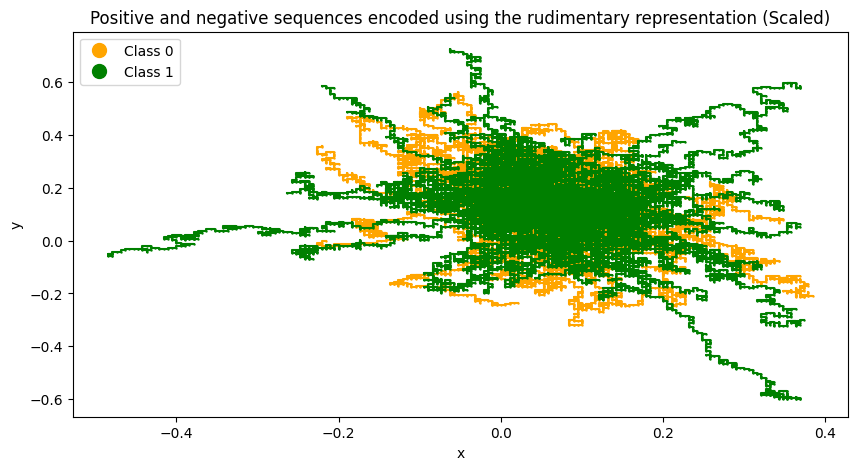

In [25]:
sampled_scaled_rudimentary_sequences = get_sample_of_scaled_sequences(
    NucleotideMappingMethod.RUDIMENTARY
)
plot_sequences(
    sampled_scaled_rudimentary_sequences,
    "Positive and negative sequences encoded using the rudimentary representation (Scaled)",
)

/tmp/ipykernel_11225/762831165.py:21: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return scaled_sequences_df.groupby("classes", group_keys=False).apply(


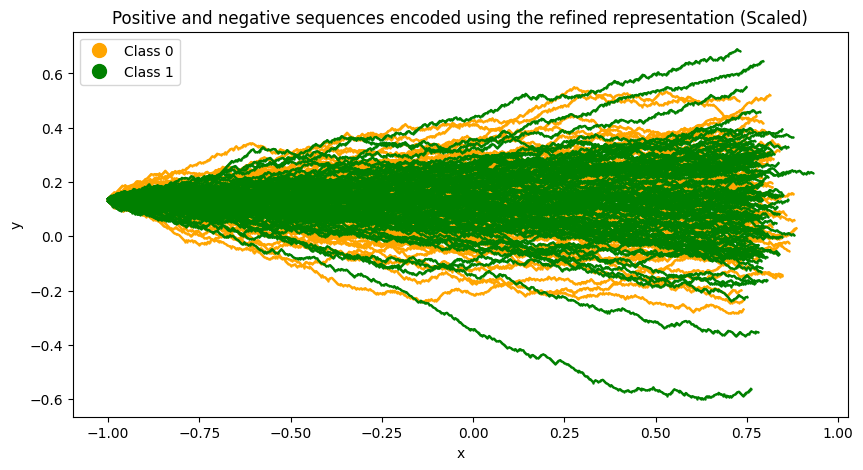

In [26]:
sampled_scaled_refined_sequences = get_sample_of_scaled_sequences(
    NucleotideMappingMethod.REFINED
)
plot_sequences(
    sampled_scaled_refined_sequences,
    "Positive and negative sequences encoded using the refined representation (Scaled)",
)

/tmp/ipykernel_11225/762831165.py:21: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return scaled_sequences_df.groupby("classes", group_keys=False).apply(


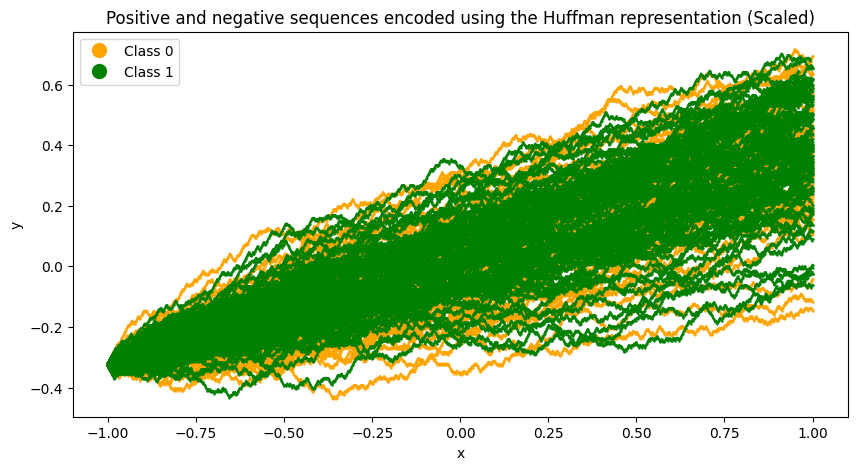

In [27]:
sampled_scaled_huffman_sequences = get_sample_of_scaled_sequences(
    NucleotideMappingMethod.HUFFMAN
)
plot_sequences(
    sampled_scaled_huffman_sequences,
    "Positive and negative sequences encoded using the Huffman representation (Scaled)",
)

In [28]:
df.to_csv("../data/classification/data.csv", index=False)